<a href="https://colab.research.google.com/github/ERerGB/Msc/blob/main/NNDL_PCoursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

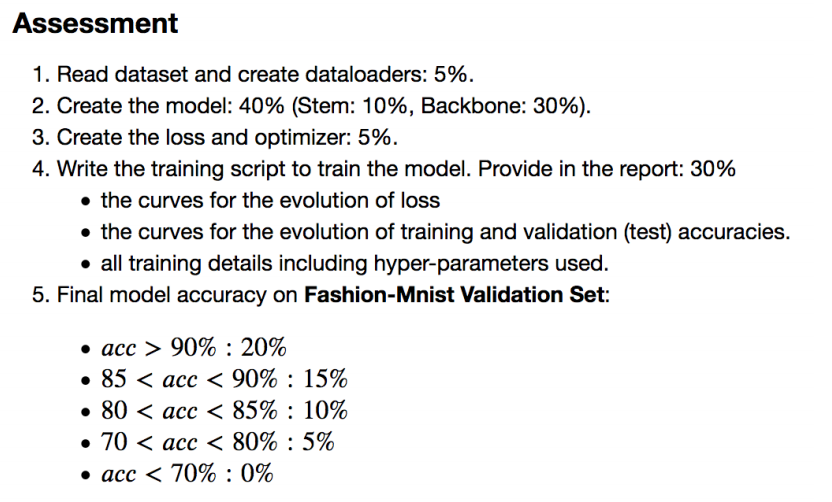

In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
import my_utils as mu
import torch
from torch import nn

In [ ]:
# Read dataset and create dataloaders
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Creat the model

In [ ]:
# Stem
class Stem(nn.Module):
    def __init__(self, kernal_size, hidden_channels, output_channels):
      super(Stem, self).__init__()
      self.kernal_size = kernal_size
      self.hidden_channels = hidden_channels
      self.output_channels = output_channels

      #self.Maxpool = nn.MaxPool2d(kernal_size, kernal_size, 0)
      self.unfold = nn.Unfold((kernal_size,kernal_size),stride = kernal_size)
      #self.Fltn = nn.Flatten()
      self.stem_Linear1 = nn.Linear(kernal_size**2,  hidden_channels)
      self.stem_Linear2 = nn.Linear(hidden_channels, output_channels)

    def forward(self, x):
      #out = self.Maxpool(x)
      #out = self.Fltn(out)
      #print(x.size())
      out = self.unfold(x).transpose(1,2)
      #print(out.size())
      #out = out.squeeze()
      #out = torch.transpose(out, 1, 2)
      #print(out.size())
      out = self.stem_Linear1(out)
      out = self.stem_Linear2(out)
      return out



In [ ]:
# Single Backbone
class Backbone(nn.Module):
    def __init__(self, input_channels, hidden_channels_1, output_channels_1, input_channels_2, hidden_channels_2, output_channels_2):
      super(Backbone, self).__init__()
      self.input_channels = input_channels
      self.hidden_channels_1 = hidden_channels_1
      self.output_channels_1 = output_channels_1
      self.input_channels_2 = input_channels_2
      self.hidden_channels_2 = hidden_channels_2
      self.output_channels_2 = output_channels_2

      self.backbone_Linear1 = nn.Linear(input_channels,hidden_channels_1)
      self.relu_1 = nn.ReLU()
      self.backbone_Linear2 = nn.Linear(hidden_channels_1,output_channels_1)
      
      self.backbone_Linear3 = nn.Linear(input_channels_2,hidden_channels_2)
      self.relu_2 = nn.ReLU()
      self.backbone_Linear4 = nn.Linear(hidden_channels_2,output_channels_2)
      

      
    def forward(self,x):
      out = x
      #print(x.size())
      #out = torch.transpose(out, 1, 2)
      #print(out.size())
      out = self.backbone_Linear1(out.transpose(1, 2))
      #print(out.size())
      out = self.relu_1(out)
      #print(out.size())
      out = self.backbone_Linear2(out)
      #print(out.size())
      #out = torch.transpose(out, 1, 2)
      #print(out.size())
      out = self.backbone_Linear3(out.transpose(1, 2))
      #print(out.size())
      out = self.relu_2(out)
      #print(out.size())
      out = self.backbone_Linear4(out)
      #print(out.size())
      #out = torch.mean(out, dim =1)
      return out


In [ ]:
class CustomNet(nn.Module):
    def __init__(self, kernal_size, hidden_channels, output_channels, bn_arch):
        super(CustomNet, self).__init__()

        input_channels = pow(int(28/kernal_size),2)
        input_channels_2 = output_channels
        self.bn_arch = bn_arch
        
        self.Stem = Stem(kernal_size, hidden_channels, output_channels)
        for i, (hidden_channels_1, output_channels_1, hidden_channels_2, output_channels_2) in enumerate(bn_arch):
            self.add_module('Backbone{0}'.format(i), Backbone(input_channels, hidden_channels_1, output_channels_1, input_channels_2, hidden_channels_2, output_channels_2))
            input_channels = output_channels_1
            input_channels_2 = output_channels_2
        
    def forward(self, x):
        out = self.Stem(x)
        for i in range(len(self.bn_arch)):
            out = self._modules['Backbone{0}'.format(i)](out)
        out = torch.mean(out, dim =1)
        #print(out.size())
        return out

In [ ]:
bn_arch = ((20,30,70,50),(20,16,30,10))
net = CustomNet(7,70,100,bn_arch)

In [ ]:
print(net)

CustomNet(
  (Stem): Stem(
    (unfold): Unfold(kernel_size=(7, 7), dilation=1, padding=0, stride=7)
    (stem_Linear1): Linear(in_features=49, out_features=70, bias=True)
    (stem_Linear2): Linear(in_features=70, out_features=100, bias=True)
  )
  (Backbone0): Backbone(
    (backbone_Linear1): Linear(in_features=16, out_features=20, bias=True)
    (relu_1): ReLU()
    (backbone_Linear2): Linear(in_features=20, out_features=30, bias=True)
    (backbone_Linear3): Linear(in_features=100, out_features=70, bias=True)
    (relu_2): ReLU()
    (backbone_Linear4): Linear(in_features=70, out_features=50, bias=True)
  )
  (Backbone1): Backbone(
    (backbone_Linear1): Linear(in_features=30, out_features=20, bias=True)
    (relu_1): ReLU()
    (backbone_Linear2): Linear(in_features=20, out_features=16, bias=True)
    (backbone_Linear3): Linear(in_features=50, out_features=30, bias=True)
    (relu_2): ReLU()
    (backbone_Linear4): Linear(in_features=30, out_features=10, bias=True)
  )
)


In [ ]:
loss = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

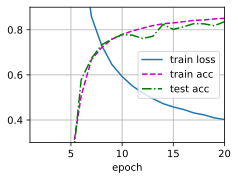

In [ ]:
num_epochs = 20
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

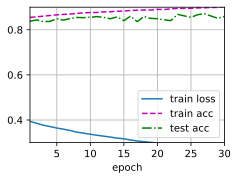

In [ ]:
num_epochs = 30
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

In [ ]:
bn_arch = ((14,12,30,20),(10,8,15,10))
net1 = CustomNet(7,40,35,bn_arch)

In [ ]:
print(net1)

CustomNet(
  (Stem): Stem(
    (unfold): Unfold(kernel_size=(7, 7), dilation=1, padding=0, stride=7)
    (stem_Linear1): Linear(in_features=49, out_features=40, bias=True)
    (stem_Linear2): Linear(in_features=40, out_features=35, bias=True)
  )
  (Backbone0): Backbone(
    (backbone_Linear1): Linear(in_features=16, out_features=14, bias=True)
    (relu_1): ReLU()
    (backbone_Linear2): Linear(in_features=14, out_features=12, bias=True)
    (backbone_Linear3): Linear(in_features=35, out_features=30, bias=True)
    (relu_2): ReLU()
    (backbone_Linear4): Linear(in_features=30, out_features=20, bias=True)
  )
  (Backbone1): Backbone(
    (backbone_Linear1): Linear(in_features=12, out_features=10, bias=True)
    (relu_1): ReLU()
    (backbone_Linear2): Linear(in_features=10, out_features=8, bias=True)
    (backbone_Linear3): Linear(in_features=20, out_features=15, bias=True)
    (relu_2): ReLU()
    (backbone_Linear4): Linear(in_features=15, out_features=10, bias=True)
  )
)


In [ ]:
lr = 0.1
optimizer = torch.optim.SGD(net1.parameters(), lr=lr)

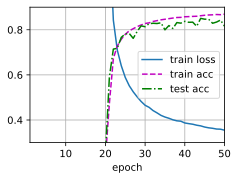

In [ ]:
num_epochs = 50
mu.train_ch3(net1, train_iter, test_iter, loss, num_epochs, optimizer)